# Basin Scale Scenario Analysis Model 

GroMore is proposing to start a new agricultural effort in the basin. Their proposal is included in the base model as the rectangular irrigated area with the elevated ET and the shallow pumping well. They are resistant to changing this plan (location of the farm, crop, location of pumping well, etc) because they have agreements with the current landowner and have done a market analysis based on the proposed pumping and the projected value of the crop. 

## Model Description 
Basin box model for scenario analysis 

#### Dimensions: 
- 50 x 50 x 3
- dx = dy = 1000 m
- dz =   

#### Topography
- Land surface elevation (base_model_elevs.csv file)
- Middle & bottom layers are horizontal.

#### Subsurface Properties: 
- Top & Bot layers 
          Kx = Ky = Kz = 10 m/day 
 
- Middle layer
          Kx = Ky = 10 m/d, 
          Kz = 10 m/d     1st 20 left most columns
          Kz = 1e-04      in the rest of the layer
 
- see NO FLOW corners in (NoFlow_Boundaries excel file)
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient = 0.0001  

#### Boundary Conditions: 
   - Right boundary is a constant head of 70 m 
   - All other boundaries are no flow
   - Note NO FLOW boundaries in the domain (see map on excel file: NoFlow_Boundaries)
   - Recharge (uniform) occurs in the 1st 15 left most columns throughout the domain. R = 4E-5 m/d 
   - ET occurs in the right half of the model domain. ET = 1e-5 m/d
   - ET_rip occurse across the riparian area in the domain (row 23 thru row 29). ET_rip = 5e-5 m/d
 
#### Wells: 
 - Water Supply well (bottom layer)
       located at (38000,21000 ) or (row 21 & col 38)
       pumping rate = 1500 m^3/d
 
 - Irrigation well (top layer)
     - Located at (14000, 12000) or (row 12 & col 14)
     - Pumping at a rate of (crop water demand)+ 0.20(excess irrig) + 0.30 (irrig inefficiency) m^3/d 
       - for wheat,Q = 3000 m^3/d
       - for Pistachio,Q = 4500 m^3/d
       - for Cotton,Q = 6000 m^3/d
 
 - Monitoring wells (top layer)
      - MW1 located at (25000, 25000)
      - MW2 located at (12500, 12500)
       
#### Irrigation Field
      - located at (18000,20000) and (20000,22000) or (row 21 & 22 and col 19 & 20)
      - 2000 m x 2000 m area.
### stream
      - runs from left to right domain boundary on row 26
      

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in C:\Users\HG\Anaconda3\lib\site-packages\flopy


## 2. Setup the input variables 

In [2]:
## Discritization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
laytyp = 1
dx= 1000 #width of grid cells in x diretion 
dy= 1000 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('top_elevn.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 124.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 10.    #horizontal hydraulic conductivity 
Kz_1 = 10      # vert hyd cond for left most 20 columns in layer 2. And, entire top & bot layers
Kz_2 = 1e-4  # vert hyd cond for the rest of columns in layer 2
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

ET = 1e-5 #m/day   unform ET over right of domain
ET_locxy =[[24000,50000],[50000,50000]]

ET_rip =5e-5
ET_rip_locxy=[[0, 22000], [50000, 28000]] #lower left and upper right corners of riparian ET in xy coordinate
extinction_depth = 10 #no extinction    

## Recharge
recharge = 4e-5 # m/day
rech_locxy = [[0,50000],[15000,50000]]  # recharge location (1st 15 left most cols)

#well
pumping1 = -1500 # m3/day      pumping rate for water supply well  
pumping2 = -3000 # m^3/d             irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = (2,well_1_row,well_1_col) #Well loc (layer, row, column)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = (0,well_2_row,well_2_col) #Well loc (layer, row, column)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
MW1_col=np.floor(MW1_xy[0]/dx-1) 
MW1_loc = (0,MW1_row,MW1_col) 

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = (0,MW2_row,MW2_col) 


#print(well_loc)
#print(well_col)


## Boundary conditions
#h_left = No flow
h_right = 70


### HINT FOR SETTING UP RECHARGE ZONES IN THE ASSIGNMENT
##Zone two properties
#z2_recharge=1e-3
#z2_llxy=[2000,3000]  #xy coordinates of lower left corner
#z2_urxy=[2000,4000] #xy coordiantes of upper right corner
##convert to rows and columns
#z2_rowll = int(np.floor((nrow-1)-(z2_llxy[1]/dy))) #convert the y location to a row
#z2_colll=int(np.floor(z2_llxy[0]/dx)-1)          #convert the x location to a column
#z2_rowur = int(np.floor((nrow-1)-(z2_urxy[1]/dy))) #convert the y location to a row
#z2_colur=int(np.floor(z2_urxy[0]/dx)-1)          #convert the x location to a column
#print(z2_colll, z2_rowll, z2_colur, z2_rowur)
## Recharge
#NOTE - Recharge applies to the top so this is always 1 layer input even when them model has more layers
#R_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
#R_zones[0,z2_rowur:z2_rowll, z2_colll:z2_colur] = z2_recharge      # assign recharge value  2 to coordinates for zone 2


In [4]:
#DEFINE RIVERS

#stress period 1 river cells
#riv_sp1 = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
#r_stage = 0.5      #stage in river (sp1)
#r_bott = 0         #river bottom

#assign river data to cells in central column  ????
for i in range(ncol):
    riv_sp1.append([0, i, ncol/2, r_stage, cond, r_bott])

riv_spd = {0: [weell_1]}

#stress period 2 river cells
#riv_sp2 = [] #create list to store all river cells for stress period 2
#r_stage = 5 #stage in river (stress period 2)
#for i in range(nrow):
    #riv_sp2.append([0, i, ncol/2, r_stage, cond, r_bott])

#stress period 3 river cells
#riv_sp3 = [] #create list to store all river cells for stress period 3
#r_stage = 1 #stage in river (stress period 3)
#for i in range(nrow):
    #riv_sp3.append([0, i, ncol/2, r_stage, cond, r_bott])


#create dictionary of stress period data
#riv_spd = {0: riv_sp1, 1: riv_sp2, 2: riv_sp3}



NameError: name 'riv_sp1' is not defined

## 3. Setup and run MODFLOW  

In [10]:
#Initialize the model
modelname1 = "Scenario_1"
moddir="C:/Users/HG/Documents/AHWR_582/AFinalPro/GroMore_Project/Tesfa/mf2005.exe"
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                 # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                 # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[0,:,:] = Kz_1 # assign vert K value to the entire array on top layer
Kz[2,:,:] = Kz_1      # assign vert K value to the entire bot layer
Kz[1,:,0:20] = Kz_1        # vert K in the middle layer for the 1st 20 left most cols
Kz[1,:,20:50] = Kz_2     # vert K in the middle layer col 20 to col 50

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array


#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#rech_zone=rech_zone+recharge

rech_rows=(np.floor(nrow-rech_locxy[1][1]/dy),np.floor(nrow-rech_locxy[0][1]/dy)) #convert the y locations to rows
rech_cols=(np.floor(rech_locxy[0][0]/dx),np.floor(rech_locxy[1][0]/dx)) #convert the y locations to rows
rech_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid

rech_zone=rech_zone+recharge

rech_zone[0,int(rech_rows[0]):int(rech_rows[1]), int(rech_cols[0]):int(rech_cols[1])] = recharge    # assign recharge rate to the ET zone



rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)     #create rch object

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET    # assign ET rate to the ET zone

evt = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

ET_rip_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_rip_locxy[0][1]/dy)) #convert the y locations to rows
ET_rip_cols=(np.floor(ET_rip_locxy[0][0]/dx),np.floor(ET_rip_locxy[1][0]/dx)) #convert the y locations to rows
ET_rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_rip_zone[0,int(ET_rip_rows[0]):int(ET_rip_rows[1]), int(ET_rip_cols[0]):int(ET_rip_cols[1])] = ET_rip    # assign ET rate to the ET zone

evt2 = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_rip_zone, exdp=extinction_depth, ipakcb=53)


#Well
well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)

well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)

wel_spd = {0: [well_1, well_2]}

wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfevt.ModflowEvt'> <class 'flopy.modflow.mfevt.ModflowEvt'>
replacing existing Package...
Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, -1500]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, -3000]
FloPy is using the following  executable to run the model: C:/Users/HG/Documents/AHWR_582/AFinalPro/GroMore_Project/Tesfa/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/15 10:26:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/15 10:26:01
 Elapsed run time:  0.269 Seconds

  Normal termination of simulation


### Add River package

In [11]:
#attach river package
riv = flopy.modflow.ModflowRiv(model=m1,stress_period_data = riv_spd, ipakcb=53)

NameError: name 'riv_spd' is not defined

# 5. Plot the domains

### Plan view of the domain

AttributeError: 'NoneType' object has no attribute 'parent'

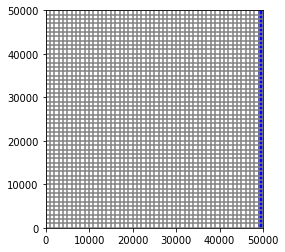

In [14]:
#use flopy to plot grid, ibound, rivers, and general head boundaries
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc(ftype='RIV')
chd_plot = modelmap.plot_bc(ftype='CHD')
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)
#fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')
#mapview = flopy.plot.PlotMapView(model=m1)
#ibound = mapview.plot_ibound()
#wel = mapview.plot_bc("WEL")
#linecollection = mapview.plot_grid()

### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

C:\Users\HG\Anaconda3\lib\site-packages\flopy\plot\plotbase.py:368: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


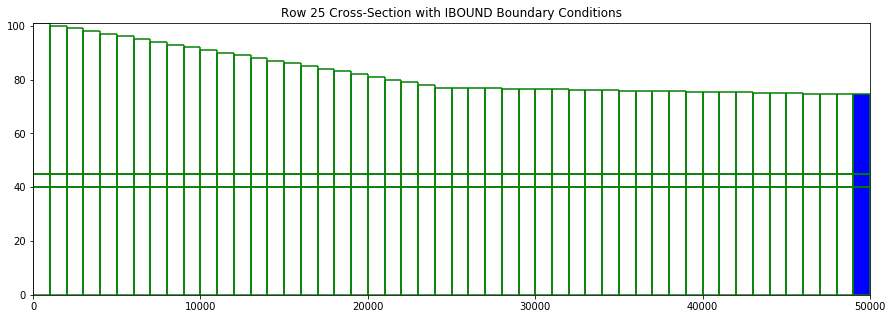

In [16]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# 5. Add particles to both scenarios


In [7]:
moddirmp="C:/Users/HG/Documents/AHWR_582/hw6-layered-Gextes/Assignment/mpath7"

#### Run model 

In [9]:
locsb = [[2, 0, 0, 2, nrow - 1, ncol-1]] #Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=3) #Number of part per cell
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb]) #setup theparticles
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

mpname1=os.path.join(modelname1 + '_mp')
print(mpname1)
mp1 = flopy.modpath.Modpath7(modelname=modelname1 + '_mp', flowmodel=m1, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp1, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp1, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp1.add_package(rch)
mp1.write_input()
mp1.run_model()
mp1.get_package_list()

ThreeLayer_mp
FloPy is using the following  executable to run the model: C:/Users/HG/Documents/AHWR_582/hw6-layered-Gextes/Assignment/mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
forrtl: severe (157): Program Exception - access violation
Image              PC                Routine            Line        Source             
mpath7.exe         00007FF7EBA07E51  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBA076E1  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBA045D5  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBA21E3D  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBA38EFE  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBAEA26E  Unknown               Unknown  Unknown
mpath7.exe         00007FF7EBAEA669  Unknown               Unknown  Unknown
KERNEL32.DLL       00007FFEE2197BD4  Unknown               Unknow

['MPBAS', 'MPSIM', 'RCH']

# 6. Read in the outputs

###  Modflow outputs - Heads and budget files

In [10]:
 #Head - 3 layer model 
headobj = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


#Water balance - 3 layer
budgobj = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj.get_unique_record_names())
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
print(len(frf))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'        RECHARGE']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'        RECHARGE']
1


### Particle outputs 

In [11]:

#Particle pathlines
fpth1 = os.path.join(mpname1 + '.mppth')
p1 = flopy.utils.PathlineFile(fpth1)

#Particle endpoints
fpth1 = os.path.join(mpname1 + '.mpend')
e1 = flopy.utils.EndpointFile(fpth1, verbose=False)

#make a subset which is all the particles
#pall3 = p3.get_alldata()  
#eall3 = e3.get_alldata()
        
#make a subset which is particles ending in the well
nodewell_1 = m1.dis.get_node([(2,well_1_row, well_1_col)])
nodewell_2 = m1.dis.get_node([(0,well_2_row, well_2_col)])
print(nodewell_1, nodewell_2)
pwell1 = p1.get_destination_pathline_data(dest_cells=nodewell1)
ewell1 = e1.get_destination_endpoint_data(dest_cells=nodewell1)

FileNotFoundError: [Errno 2] No such file or directory: 'OneLayer_mp.mppth'

# 6. Plotting
#### Cross section plots

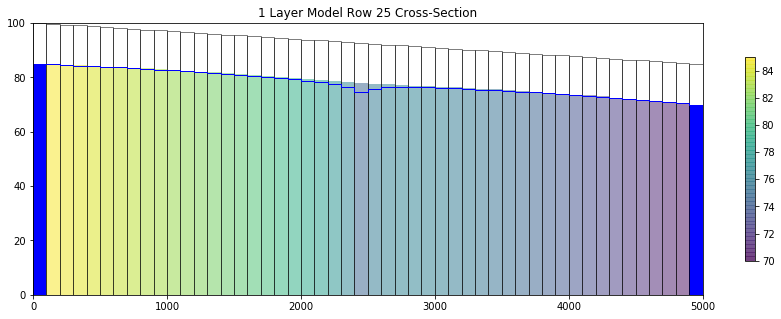

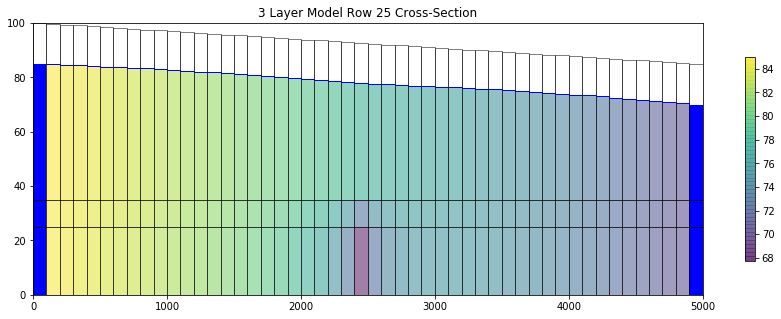

In [12]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)


#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)


### Plot particle pathlines

NameError: name 'pwell3' is not defined

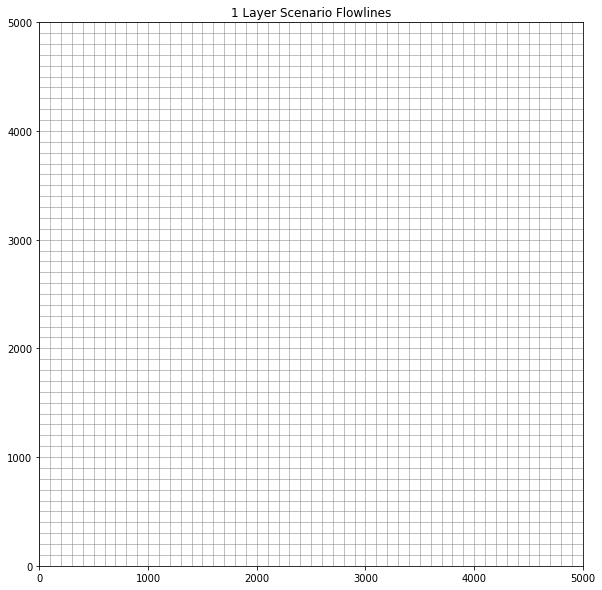

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('1 Layer Scenario Flowlines')
mm = flopy.plot.PlotMapView(model=m1, ax=ax)
mm.plot_grid(lw=0.5)
#mm.plot_pathline(pall1, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell3, layer='all', color='red', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell1, layer='all', color='orange', lw=0.5, linestyle=':', label='1 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();
#plt.tight_layout();
#plt.savefig('Pathlines.png')

# Additional plots
### Plot head transect

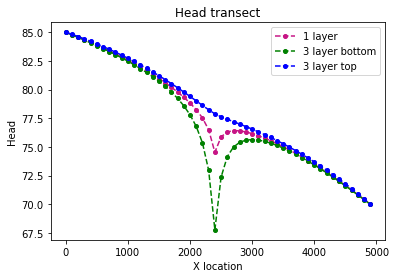

In [14]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,50000,1000) 
plt.plot(x,head[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.plot(x,head[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()
plt.savefig('Head_Transect.png')


### 3 Layer head contours

[ 0.         -0.10253461 -0.20611505 -0.3117753  -0.42052126 -0.53331316
 -0.651048   -0.7745218  -0.90439916 -1.0411651  -1.1850691  -1.3360555
 -1.4936836  -1.6570538  -1.8247138  -1.9945931  -2.1639478  -2.329357
 -2.4867728  -2.6316578  -2.7592087  -2.864676   -2.9437482  -2.9929583
 -3.010061   -2.9942808  -2.9464123  -2.8687205  -2.7646885  -2.6386492
 -2.4953744  -2.3396888  -2.1761532  -2.0088422  -1.8412062  -1.676017
 -1.5153809  -1.3607844  -1.2131697  -1.0730166  -0.94043183 -0.81521475
 -0.6969366  -0.58499104 -0.47864294 -0.37706333 -0.2793595  -0.18459527
 -0.09180462  0.        ]


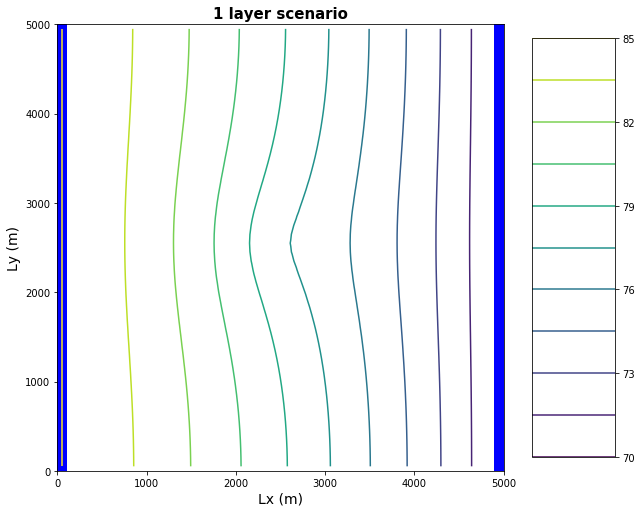

In [17]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
print(fff1[0][0][40])
#print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
#flows = modelmap.plot_discharge(frf3[0][0], fff3[0][0], head=head3[0]) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   